# How and what affects the review scores of airbnb most; price, hosts, or location?

Sydney Airbnb Data Listing

Karen Stevani (z5573992)

In [195]:
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gp
import numpy as np
import plotly.graph_objects as go
from datetime import datetime
import shapely
import fiona
import math
import requests
import zipfile
import folium
import plotly.express as px
import contextily as ctx
from scipy.stats import pointbiserialr

In [132]:
%matplotlib inline

In [133]:
plt.rcParams["figure.figsize"] = (30, 15)

In [134]:
saved_style_state = matplotlib.rcParams.copy()  # give us a style state to go back to

In [135]:
#loading from file
if os.path.isfile("sydney_airbnb_listing.csv"):
    filepath = "sydney_airbnb_listing.csv"
    print("loading from file")
else:
    filepath = "https://data.insideairbnb.com/australia/nsw/sydney/2024-03-16/data/listings.csv.gz"
    print("loading from the internet")

listing_data = pd.read_csv(filepath)
print("done")

loading from file
done


Data Set: "Detailed Sydney Listings data" from insideairbnb.com

Published by: Inside Airbnb, licensed under a Creative Commons Attribution 4.0 International License, on 10 June 2024

With a total of 14274 rows and 75 columns, this dataset explores Sydney's airbnb market that has steadily started from the year of 2009 to current times. It provides information of hosts behaviors (name, id, verification, address, the time they started, response rate, response time, listing count, the license they used, and more), listing informations (price, longitude, latitude, availability, how many person it accommodates, amount of rooms and bathrooms, facilities, property type and more), and various reviews related to it.

Sydney, a place with one of the highest housing market prices right now, is an area that is highly famous with tourism. Because of this, airbnbs play a pivotal role in providing shelter for tourists and sometimes even for longer stays of immigrants or locals in the area. Which is why through this data project, comparisons of price, host, and locations are analyzed to see whether and how much they affect each other. As well as if they correlate to the review scores and should affect your choice in booking an airbnb.

In [136]:
listing_data.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1050164598350388320,https://www.airbnb.com/rooms/1050164598350388320,20240316023820,2024-03-18,city scrape,Self service English breakfast,Close to transport airport older style unit ne...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,211218678,...,NaN,NaN,NaN,PID-STRA-61891,f,1,0,1,0,NaN
1,1096082243192434668,https://www.airbnb.com/rooms/1096082243192434668,20240316023820,2024-03-18,city scrape,Apartment in Rushcutters Bay,Full 2 bedroom apartment with balcony. Walking...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,26721338,...,NaN,NaN,NaN,Exempt,f,2,1,1,0,NaN
2,2167538,https://www.airbnb.com/rooms/2167538,20240316023820,2024-03-18,city scrape,"Modern Sydney home near beach,shops",**Availability extremely flexible**<br /><br /...,Queens Park is a safe and friendly neighbourho...,https://a0.muscache.com/pictures/29922910/2399...,11059668,...,5.00,5.00,4.00,NaN,f,1,1,0,0,0.01
3,790607305500629830,https://www.airbnb.com/rooms/790607305500629830,20240316023820,2024-03-18,city scrape,Luxury double room,Relax in this tranquil and stylish space.,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,202112801,...,4.77,4.68,4.68,PID-STRA-21723,f,30,5,25,0,2.13
4,641106357139201992,https://www.airbnb.com/rooms/641106357139201992,20240316023820,2024-03-18,city scrape,Chic Studio Apartment in Prime Bondi Location,Immerse yourself in the vibrant atmosphere of ...,Bondi is one of Australia’s most iconic suburb...,https://a0.muscache.com/pictures/prohost-api/H...,279001183,...,3.94,4.94,4.29,PID-STRA-36651,f,217,217,0,0,0.84


In [137]:
listing_data.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

#### 1. Value (Price)

Value that is discussed here is in relation to pricing. As potential customers, we are always looking for reasonable value for our money's worth, especially in Sydney's curent intense housing market state. Although there are also aspects that affects pricing itself, such as the amount of space, facilities, location, hygiene, estate's age and more, this filtration process will mainly focus on standardizing the price for accomodating one person's living and the average price airbnb price for one person as a benchmark.

In [138]:
listing_data.price

0        $100.00
1        $250.00
2        $650.00
3         $84.00
4        $508.00
          ...   
14269     $88.00
14270    $143.00
14271    $120.00
14272    $180.00
14273    $123.00
Name: price, Length: 14274, dtype: object

In [139]:
listing_data.accommodates

0        2
1        4
2        5
3        1
4        2
        ..
14269    2
14270    2
14271    4
14272    2
14273    2
Name: accommodates, Length: 14274, dtype: int64

In [140]:
listing_data['price'] = listing_data['price'].replace({'\$': '', ',': ''}, regex=True)
listing_data['price'] = pd.to_numeric(listing_data['price'], errors='coerce').astype('Int64')  # Use 'Int64' to handle NaN values
listing_data['price'] = listing_data['price'].fillna(0).astype(int)

<>:1: SyntaxWarning:

invalid escape sequence '\$'

<>:1: SyntaxWarning:

invalid escape sequence '\$'

C:\Users\karen\AppData\Local\Temp\ipykernel_46404\2283849491.py:1: SyntaxWarning:

invalid escape sequence '\$'



In [141]:
listing_data['standard_price'] = listing_data['price'] / listing_data['accommodates']
listing_data.standard_price

0         50.0
1         62.5
2        130.0
3         84.0
4        254.0
         ...  
14269     44.0
14270     71.5
14271     30.0
14272     90.0
14273     61.5
Name: standard_price, Length: 14274, dtype: float64

In [142]:
average_price = listing_data['price'].mean()
print(f"The average price is: ${average_price}")

average_standard_price = listing_data['standard_price'].mean()
print(f"The average price per person is: ${average_standard_price}")

The average price is: $395.94689645509317
The average price per person is: $95.22062845427966


Through taking data from the price column and corresspondingly, the accommodates column, I am able to manipulate their data types to create a new column that divides the two values together respectively. This allows a more standardized price that will allow a fairer comparison later with other categories. I also extracted the average price to book an airbnb in sydney for future reference, which are roughly $396 for its original non standerdized price and $95 as the average for one airbnb night booking per person.

#### 2. Hosts

Hosts are the landlords of airbnbs. They are the owners of the airbnb property and sometimes lives in the property they are listing. There are many information categories that are provided of the host in this dataset. Some of the more interesting ones include where they are located and the license they used for verification. But for the main exploration of host's correlation to review scores and the other two aspects being questioned, the duration length of them being hosts is the main focused column

In [143]:
listing_data.host_identity_verified.value_counts()

host_identity_verified
t    13605
f      669
Name: count, dtype: int64

<Figure size 500x250 with 0 Axes>

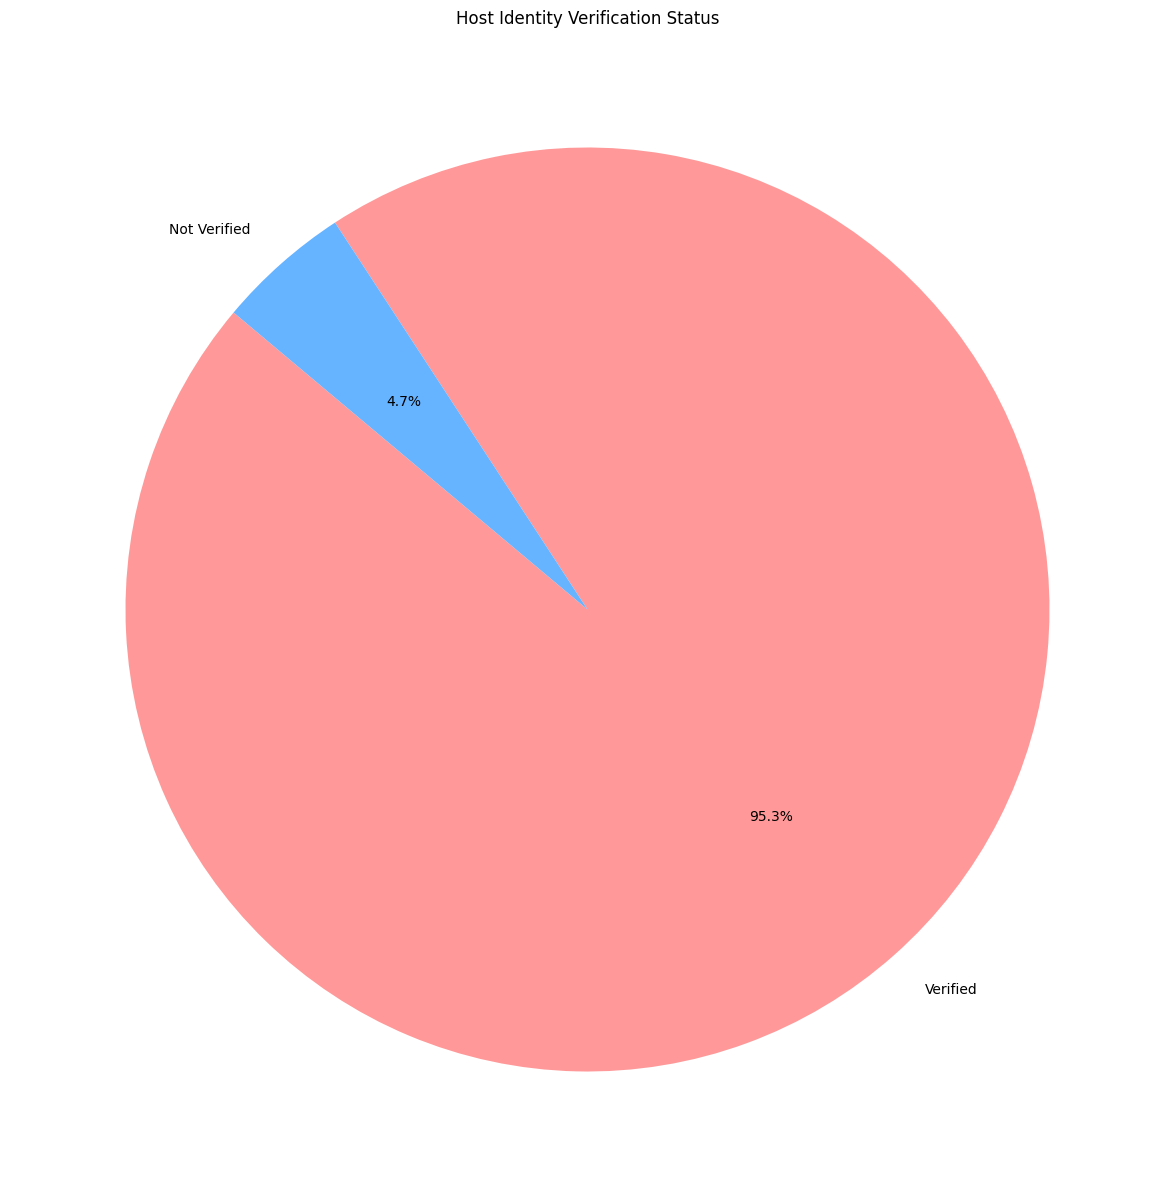

In [144]:
data = {'Status': ['Verified', 'Not Verified'], 'Count': [13605, 669]}
licensepie = pd.DataFrame(data)

plt.figure(figsize=(5, 2.5))
licensepie.set_index('Status').plot.pie(y='Count', autopct='%1.1f%%', colors=['#ff9999','#66b3ff'], legend=False, startangle=140)
plt.title('Host Identity Verification Status')
plt.ylabel('')
plt.show()

As seen from the data, majority of hosts (95.3%) are verified with their status as a host, whereas a minority of 7.4% are not. This will be explored further later if it causes any effect on the airbnb reviews. 

In [145]:
listing_data.host_since

0        2018-08-22
1        2015-01-26
2        2014-01-06
3        2018-07-13
4        2019-07-24
            ...    
14269    2015-02-23
14270    2015-12-21
14271    2022-07-03
14272    2023-10-07
14273    2017-10-08
Name: host_since, Length: 14274, dtype: object

In [146]:
listing_data['host_since'] = pd.to_datetime(listing_data['host_since'])
date_format_pattern = "%B, %Y"
earliest_date = datetime.strftime(listing_data.host_since.min(), date_format_pattern)
latest_date = datetime.strftime(listing_data.host_since.max(), date_format_pattern)
f"The range of someone becoming an airbnb host in Sydney is {earliest_date} to {latest_date}"

'The range of someone becoming an airbnb host in Sydney is June, 2009 to March, 2024'

In [147]:
listing_data['host_since'] = pd.to_datetime(listing_data['host_since'])
reference_date = pd.Timestamp('2024-08-01')
listing_data['days_since_start'] = (reference_date - listing_data['host_since']).dt.days
listing_data.days_since_start

0        2171
1        3475
2        3860
3        2211
4        1835
         ... 
14269    3447
14270    3146
14271     760
14272     299
14273    2489
Name: days_since_start, Length: 14274, dtype: int64

In [148]:
average_age_as_host = listing_data['days_since_start'].mean()
print(f"The average age someone has become an airbnb host in Sydney is {average_age_as_host} days")

The average age someone has become an airbnb host in Sydney is 2615.159030404932 days


After calculations, the average duration someone has become an airbnb host in Sydney is 2622.159030404932 days or roughly about 7 years, 2 months, and 5 days. Meaning most airbnb hosts, started listing around 2017. With the new column calculated of how long (in terms of days) each person has become an airbnb host in Sydney, this allows comparison graph of the host compared to the other aspects issued and the main review scores.

#### 3. Location

In [149]:
shp_file_name = r"C:\Users\karen\1161\course\maps\gda2020\nsw_localities.shp"
zip_file_name = "nsw_locality_polygon_shp.zip"
web_file_path = (
    "https://data.gov.au/data/dataset/"
    "91e70237-d9d1-4719-a82f-e71b811154c6/resource/"
    "5e295412-357c-49a2-98d5-6caf099c2339/download/"
    "nsw_locality_polygon_shp.zip"
)

In [150]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

In [151]:
def unzip_zipfile(zipped_file_path, put_it_here="."):
    import zipfile
    zip_of_suburbs = zipfile.ZipFile(zipped_file_path, 'r')
    zip_of_suburbs.extractall(put_it_here)
    zip_of_suburbs.close()

In [152]:
# Get the data loaded. This is a bit complicated because it's online as a zip file.
# If we don't have it right now, we need to get it and unzip it.
if os.path.isfile(shp_file_name):
    print("loading from file")
else:
    if os.path.isfile(zip_file_name):
        print("unzipping")
        unzip_zipfile(zip_file_name)
    else:
        import requests
        print("loading from the internet")
        page = requests.get(web_file_path)
        with open(zip_file_name, 'wb') as z:
            z.write(page.content)
        unzip_zipfile(zip_file_name)

print("done")

loading from file
done


In [153]:
burbs = gp.GeoDataFrame.from_file(shp_file_name)
burbs.set_crs(epsg=5234, inplace=True, allow_override=True) 
# https://epsg.io/8021
# GDA2020 is the latest and least wrong coord set for Sydney
burbs.sample(2)

,LC_PLY_PID,LOC_PID,DT_CREATE,LOC_NAME,LOC_CLASS,STATE,geometry
4257,lcpa1b6755db324,loc74f8e9178b48,2021-06-24,Warri,Gazetted Locality,NSW,"POLYGON ((149.701 -35.289, 149.701 -35.289, 14..."
957,lcpcf360c153a30,loc19e6b177ff58,2021-06-24,Clear Creek,Gazetted Locality,NSW,"POLYGON ((149.751 -33.289, 149.752 -33.289, 14..."


In [154]:
# Sample DataFrame with your actual data
maplist = pd.DataFrame({
    'longitude': listing_data.longitude,  # Replace with your actual longitude data
    'latitude': listing_data.latitude,  # Replace with your actual latitude data
})

# Convert DataFrame to GeoDataFrame
gdf_maplist = gp.GeoDataFrame(
    maplist, 
    geometry=gp.points_from_xy(listing_data.longitude, listing_data.latitude),
    crs="EPSG:4326"  # Set CRS to WGS84
)

In [155]:
# Create a scatter mapbox plot
fig = px.scatter_mapbox(listing_data, 
                        lat='latitude', 
                        lon='longitude',
                        title='Interactive Sydney Airbnb Map',
                        mapbox_style="carto-positron",
                        zoom=10)
fig.show()

Seen from the map, the locations of sydney airbnbs are quite evenly distributed. However, it is most concentrated around the are of Darlinghurst, Haymarket and Koreatown, as well as around Bondi beach. This shows that even when renting airbnbs originally stemmed from an attempt to earn a little more money, unlike back in 2009, it has become quite a serious and growing financial industry, similar to hotels, targeting more famous and tourist centric areas.

#### Correlation between

##### Price and Host Verification

In [156]:
verified_hosts = listing_data[listing_data['host_identity_verified'] == 'yes']
non_verified_hosts = listing_data[listing_data['host_identity_verified'] == 'no']

In [157]:
filtered_price = listing_data[(listing_data['standard_price'] >= 0) & (listing_data['standard_price'] <= 200)]

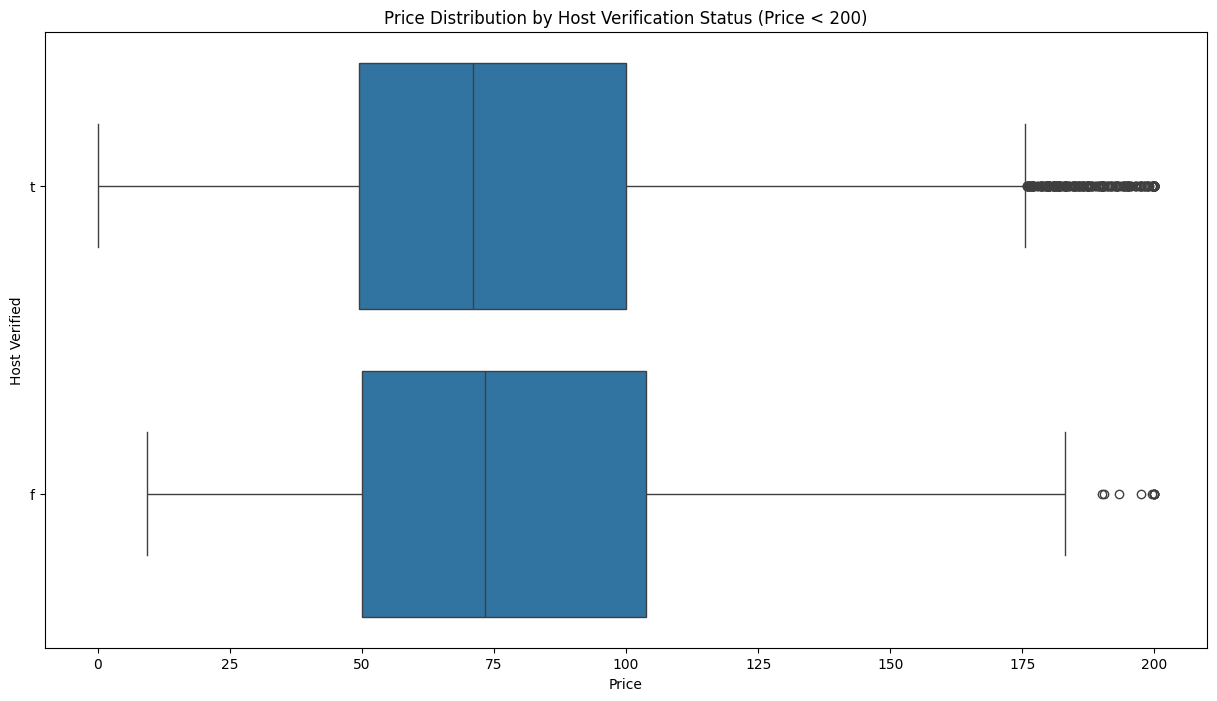

In [158]:
plt.figure(figsize=(15, 8))
sns.boxplot(x='standard_price', y='host_identity_verified', data=filtered_price)
plt.title('Price Distribution by Host Verification Status (Price < 200)')
plt.xlabel('Price')
plt.ylabel('Host Verified')
plt.show()

From this clearer view of the box and whiskers graph of price distribution on host's verification status, we can see that a host's status doesn't really affect the price of airbnbs. The difference is extremely slight, although suprisingly with host verified having lower price median and price range overall. However as seen above, there are more outliers in the 'True' verification bar. So with the nature of box and whiskers that analyze about 50% or more of where data falls, but not all, this doesn't necessarily shows the true average price per person. Considering for this dataset, still a huge number of real existing prices of perhaps fancier listings, are deemed as immediate outliers. Which is why when average is calculated and compared between the two, a verified host still holds higher value than a non verified host. The outcome of the box and whiskers above could also be affected due to the bigger range of verified host (95.3%) compared to the non verified (4.7%), meaning percentage of finding listings with lower prices are more likely than a smaller dataset.

C:\Users\karen\AppData\Local\Temp\ipykernel_46404\1603925362.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




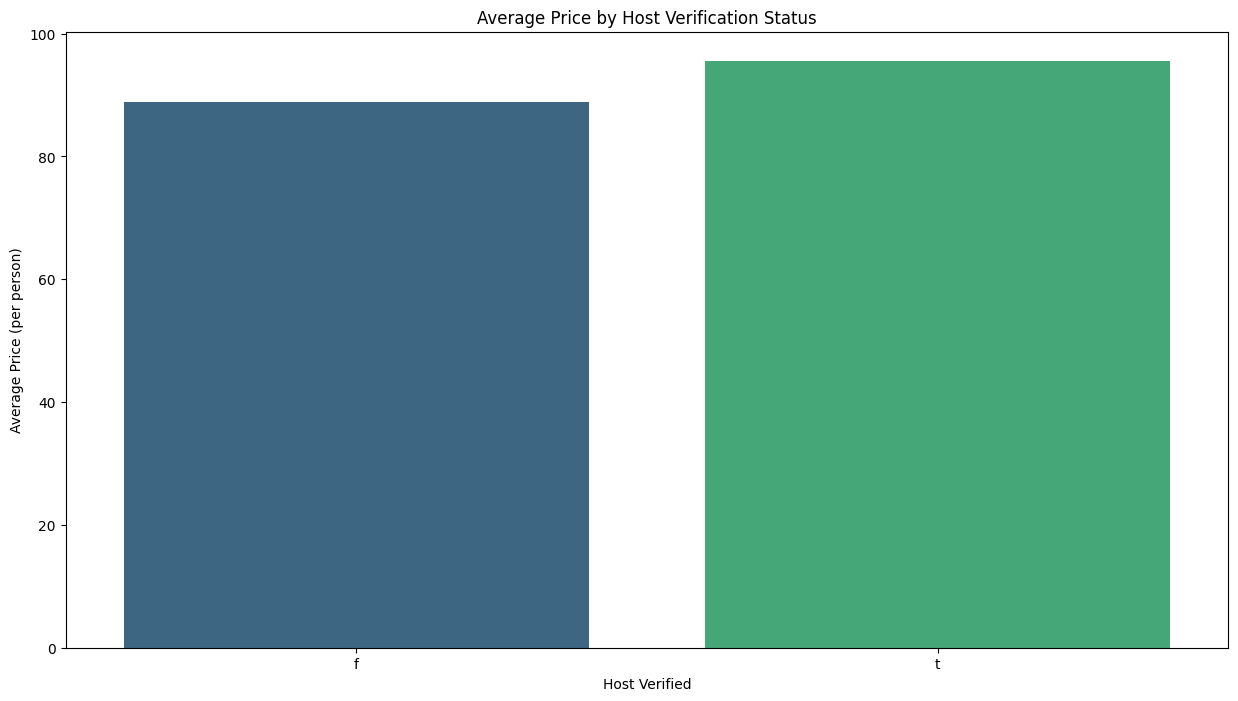

In [159]:
mean_prices = listing_data.groupby('host_identity_verified')['standard_price'].mean().reset_index()

plt.figure(figsize=(15, 8))
sns.barplot(x='host_identity_verified', y='standard_price', data=mean_prices, palette='viridis')
plt.title('Average Price by Host Verification Status')
plt.xlabel('Host Verified')
plt.ylabel('Average Price (per person)')
plt.show()

##### Price and Duration a Person has become Host

In [160]:
def nearest_multiple_of_100(x):
    return (x // 100) * 100

listing_data['duration_multiple_of_100'] = listing_data['days_since_start'].apply(nearest_multiple_of_100)
average_price_by_duration = listing_data.groupby('duration_multiple_of_100')['standard_price'].mean().reset_index()
average_price_by_duration.columns = ['Duration (Days Multiple of 100)', 'Average Price']
print(average_price_by_duration)

    Duration (Days Multiple of 100)  Average Price
0                               100      71.330116
1                               200     139.547254
2                               300      72.132421
3                               400      72.959692
4                               500      73.143014
5                               600      94.887738
6                               700      73.314745
7                               800      74.111902
8                               900      75.453864
9                              1000      89.312608
10                             1100      85.797861
11                             1200      91.157850
12                             1300      78.362602
13                             1400      86.829747
14                             1500      98.513473
15                             1600      94.261619
16                             1700      85.856558
17                             1800      84.468748
18                             

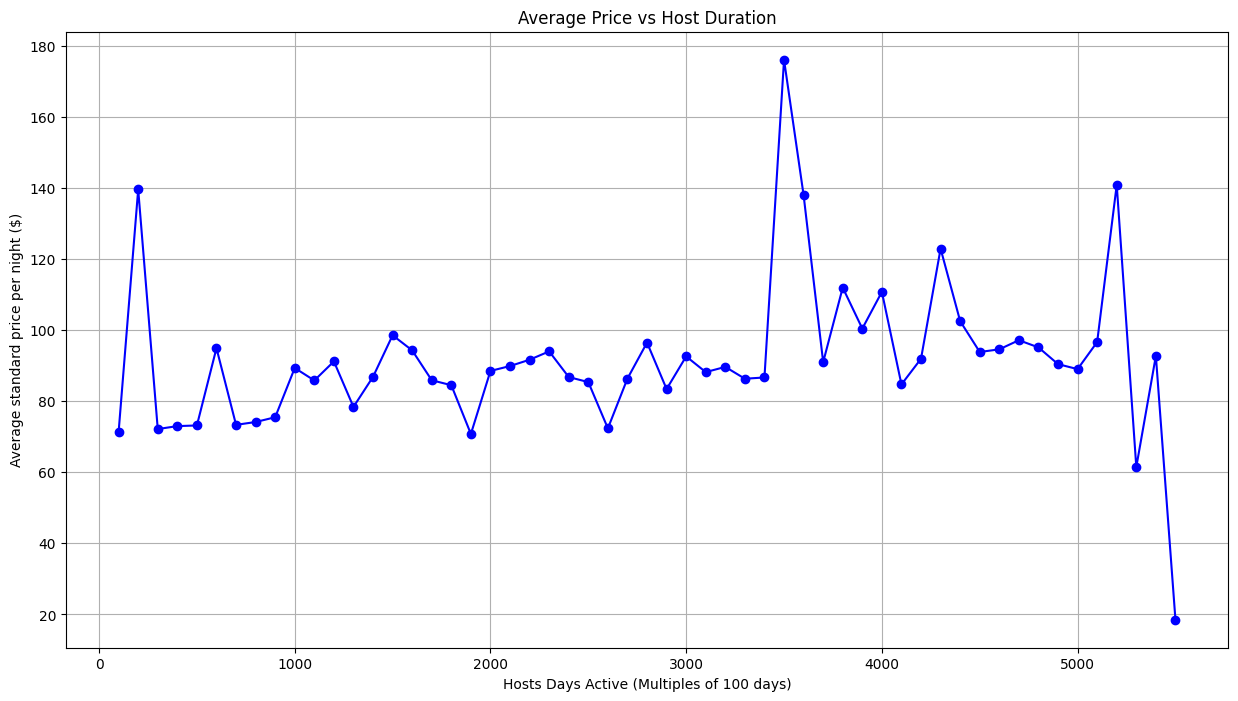

In [174]:
plt.figure(figsize=(15, 8))

plt.plot(
    average_price_by_duration['Duration (Days Multiple of 100)'], 
    average_price_by_duration['Average Price'], 
    marker='o', 
    linestyle='-', 
    color='b'
)

plt.xlabel('Hosts Active Days (Multiples of 100 days)')
plt.ylabel('Average standard price per night ($)')
plt.title('Average Price vs Host Active Days')
plt.grid(True)
plt.show()

Next, from this linegraph, we can see that unexpectedly, people that have become hosts for 100 (3 months), 3500 (9 years and 7 months), 3600 (9 years and 10 months) and 5200 (14 years and 2 months) days sets higher prices than others. The prices average about $140 per person for a night, which is about $20 more expensive than the second highest prices and about $40 more expensive than the average prices of others.

Some of the most drastic change are also prevelant in an increase between people that just started becoming a host to people who have been hosts for 3 months, with a massive $70 jump. This may be due to new hosts being unfamiliar to the average prices in the market and concerns of renting possibilities over competitors with their new experience. Afterwards, the increase shows their risk taking and assurance of price setting from the market. Contrastingly, one of the lowest drop in price is seen from older hosts (from 14 years and 9 months to 15 years), with a drop of $70. This may be due to their consequently older property too, serving less value for rent. 

Although there really isn't a clear pattern of price increase or decline throughout the duration length of a host, it is notable that the lowest prices are set by hosts that started for less than 3 months or closer to 15 years (in this case, started at 2009). Hence, as customers in a budget, targeting these two range might be best. Although obviously this neglects and doesn't take into account the living condition and host service, which may be very different for other hosts that sets higher prices. Which is why rating scores will be further explored later to this to see if quality difference is not massive enough to sacrifice for price.

##### Price and Location

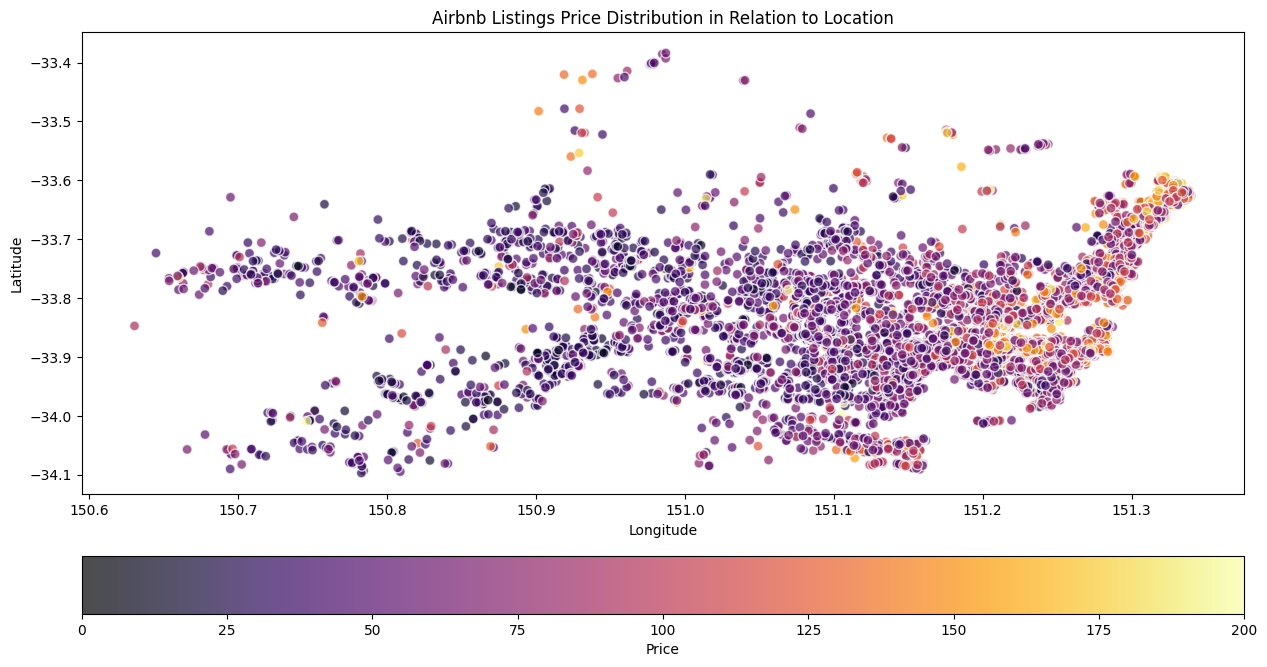

In [162]:
fig, ax = plt.subplots(figsize=(15, 8))

scatter = ax.scatter(
    filtered_price['longitude'], 
    filtered_price['latitude'], 
    c=filtered_price['standard_price'], 
    cmap='inferno', 
    s=50, 
    alpha=0.7, 
    edgecolors='w'
)

cbar = plt.colorbar(scatter, orientation='horizontal', pad=0.1, ax=ax)
cbar.set_label('Price')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Airbnb Listings Price Distribution in Relation to Location')

plt.show()

Next, for price and location correlation (through limiting price below 200 for clearer and more specified distribution), we can see that brighter plots and values are seen more near the coastlines. This could be due to several reasons such as:
1. It is more of a tourist attraction, hence demand is higher
2. It provides more scenic views and is closer to nature, which is one of the reason Sydney is famous for
3. Closer to areas that facilitate more activities (surfing, fishing, and more)
4. It's harder to maintain, as land can be lost to the ocean and property may erode and breaks faster (or material cost is higher for a secure building)
5. Price market is higher, stemming since age old history where properties near beaches are more desired due to its heavy and more accessible trade environment 

##### Duration a Person is Host and Location

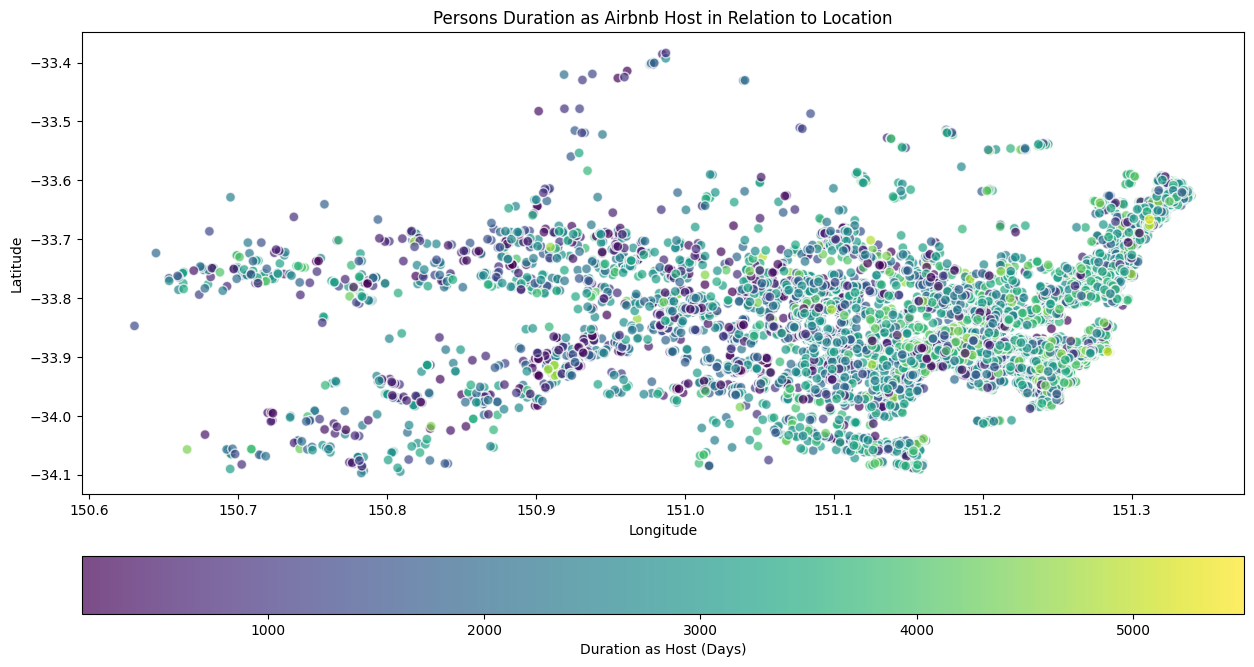

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))

scatter = ax.scatter(
    filtered_price['longitude'], 
    filtered_price['latitude'], 
    c=filtered_price['days_since_start'], 
    cmap='viridis', 
    s=50, 
    alpha=0.7, 
    edgecolors='w'
)

cbar = plt.colorbar(scatter, orientation='horizontal', pad=0.1, ax=ax)
cbar.set_label('Duration as Host (Days)')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Persons Duration as Airbnb Host in Relation to Location')

plt.show()

Another quite evenly distributed location for old and new airbnb hosts in Sydney. However notably from the graph, areas near the coastline, which were analyzed before to have more expensive prices, are mostly listed by hosts that started 2500 days (6 years and 10 months), which correlated from before tends to list propereties for 80-100 dollars for value. Hosts that have been renting for more than 5000 days and were established before to set significantly cheaper prices, are also found in these beach coasts, which shows that although price market tends to be higher there, a few airbnbs that are some of the cheapest in entirety of Sydney can be found there too. Aside from that, most listings in the southern area mainly has hosts leasing for 2000-3000 days (5 years and 5 months to 8 years and 2 months) and trends of newer hosts can be seen as airbnb location gets closer to the west parts

#### How it affects Review Scores

Now that we have seen their trends with each other, let us analyze these four categories to its correlation with review scores. With assumptions that review scores provides reliability of renting quality preview, we can see whether these aspects should be considered when renting or not based on the correlation strength.

##### Price and Rating

In [ ]:
listing_data.review_scores_rating

0         NaN
1         NaN
2        4.00
3        4.71
4        4.00
         ... 
14269    4.57
14270    4.87
14271    4.96
14272     NaN
14273    4.98
Name: review_scores_rating, Length: 14274, dtype: float64

In [ ]:
listing_data['review_scores_rating'] = pd.to_numeric(listing_data['review_scores_rating'], errors='coerce')
average_review_score = listing_data['review_scores_rating'].mean()
print(f'Average review score is {average_review_score} out of 5')

Average review score is 4.711222399462682 out of 5


C:\Users\karen\AppData\Local\Temp\ipykernel_46404\4285475227.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



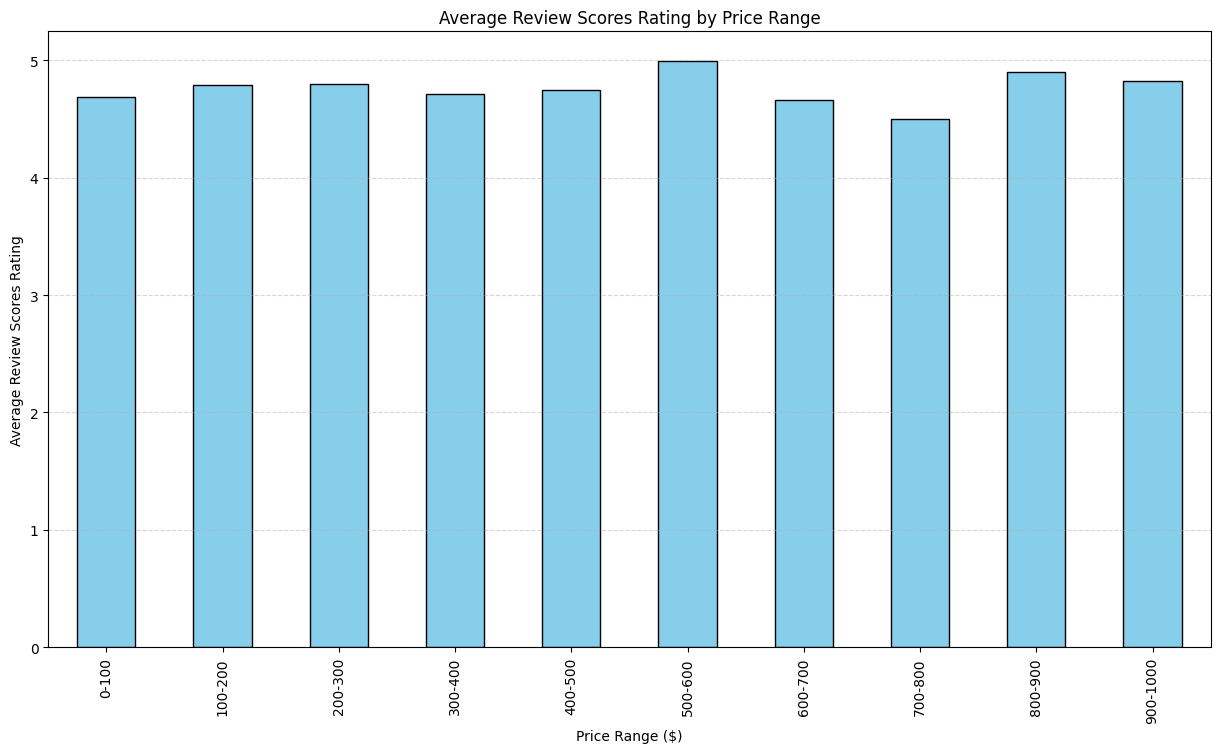

In [ ]:
price_bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]  # Define your price ranges
price_labels = ['0-100', '100-200', '200-300', '300-400', '400-500', '500-600', '600-700', '700-800', '800-900', '900-1000']  # Labels for the bins

listing_data['price_range'] = pd.cut(listing_data['standard_price'], bins=price_bins, labels=price_labels, include_lowest=True)

avg_review_scores = listing_data.groupby('price_range')['review_scores_rating'].mean()

fig, ax = plt.subplots(figsize=(15, 8))

avg_review_scores.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')

ax.set_xlabel('Price Range ($)')
ax.set_ylabel('Average Review Scores Rating')
ax.set_title('Average Review Scores Rating by Price Range')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

As seen from the price to review scores rating, there really isn't a set pattern of increasing price equating increasing quality. However $500-600 prices seems to have the highest rating and $700-800 seems to be the price range to avoid, because the rating doesn't reflect its absurd value. Now as my project has been focusing on $0-200 standard prices, I'll zoom the graph and refer back to the filtered price with upper bound of $200. 

C:\Users\karen\AppData\Local\Temp\ipykernel_46404\1064015898.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\karen\AppData\Local\Temp\ipykernel_46404\1064015898.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



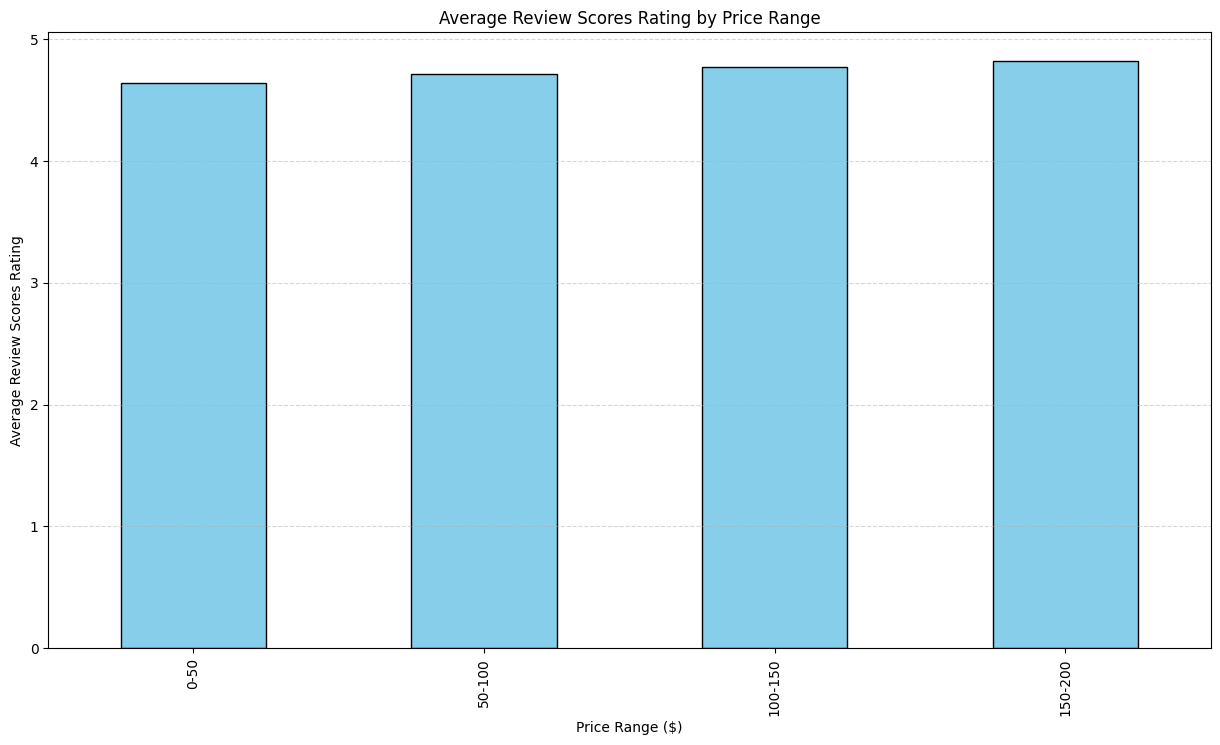

In [ ]:
price_bins = [0, 50, 100, 150, 200]
price_labels = ['0-50', '50-100', '100-150', '150-200']
filtered_price['price_range'] = pd.cut(filtered_price['standard_price'], bins=price_bins, labels=price_labels, include_lowest=True)

avg_review_scores = filtered_price.groupby('price_range')['review_scores_rating'].mean()
fig, ax = plt.subplots(figsize=(15, 8))
avg_review_scores.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')

ax.set_xlabel('Price Range ($)')
ax.set_ylabel('Average Review Scores Rating')
ax.set_title('Average Review Scores Rating by Price Range')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

With the filtered standard price, there seem to be a slight upward increase for every $50 group range increase. Though the difference isn't a lot and they all still fall under 4.5-5 stars rating score. Hence this shouldn't affect your final booking decision, and desired budget goal should just be referred instead. 

##### Host Verification and Rating

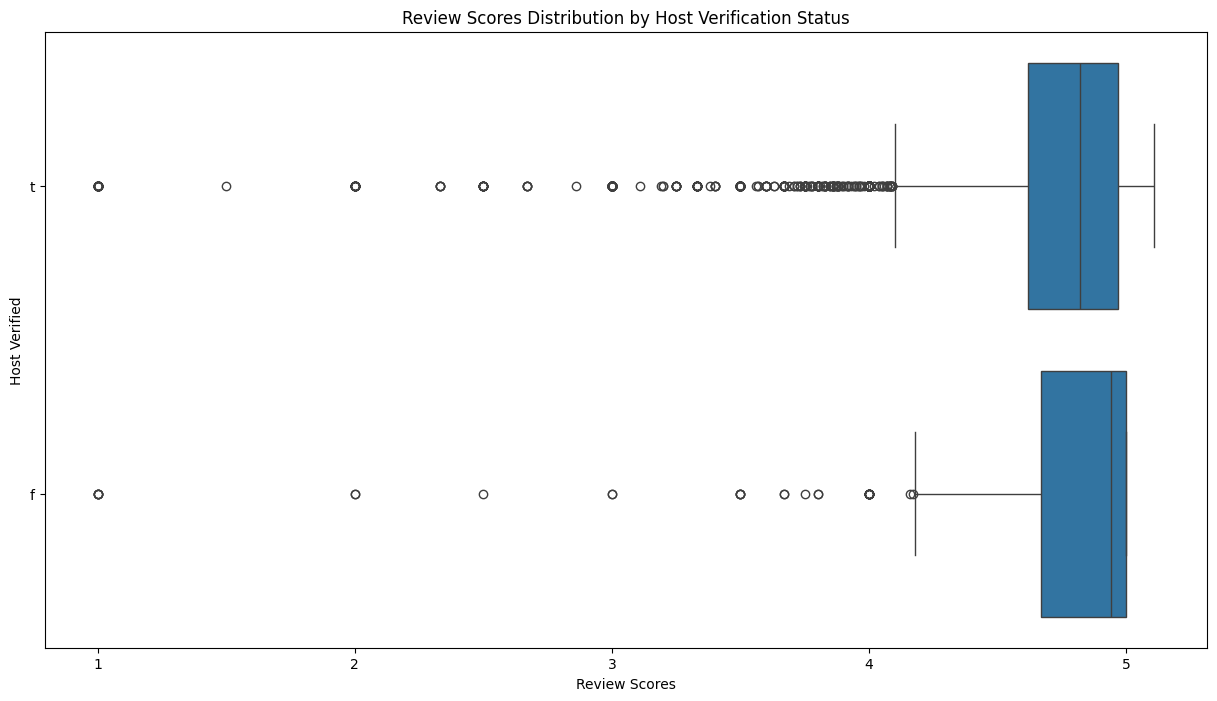

In [177]:
plt.figure(figsize=(15, 8))
sns.boxplot(x='review_scores_rating', y='host_identity_verified', data=filtered_price)
plt.title('Review Scores Distribution by Host Verification Status')
plt.xlabel('Review Scores')
plt.ylabel('Host Verified')
plt.show()

Suprisingly, as shown from the graph above, unverified hosts have a slightly higher range and median for review scores rating. They also have less assumed outliers by python compared to the verified ones. Again, this may be due to the smaller data pool with only 4.7%  of the entire Sydney airbnb host. However this goes to show that even with a slightly higher price range, but lower average price range compared to verified hosts, unverified hosts are not an unreliable alternative to opt for.

##### Host Duration and Rating

In [168]:
def nearest_multiple_of_100(x):
    return (x // 100) * 100

listing_data['duration_multiple_of_100'] = listing_data['days_since_start'].apply(nearest_multiple_of_100)
average_rating_by_duration = listing_data.groupby('duration_multiple_of_100')['review_scores_rating'].mean().reset_index()
average_rating_by_duration.columns = ['Duration (Days Multiple of 100)', 'review_scores_rating']
print(average_rating_by_duration)

    Duration (Days Multiple of 100)  review_scores_rating
0                               100              4.766531
1                               200              4.509442
2                               300              4.612905
3                               400              4.678875
4                               500              4.639880
5                               600              4.642159
6                               700              4.603052
7                               800              4.759134
8                               900              4.746000
9                              1000              4.612062
10                             1100              4.661277
11                             1200              4.706173
12                             1300              4.719388
13                             1400              4.698061
14                             1500              4.545304
15                             1600              4.657449
16            

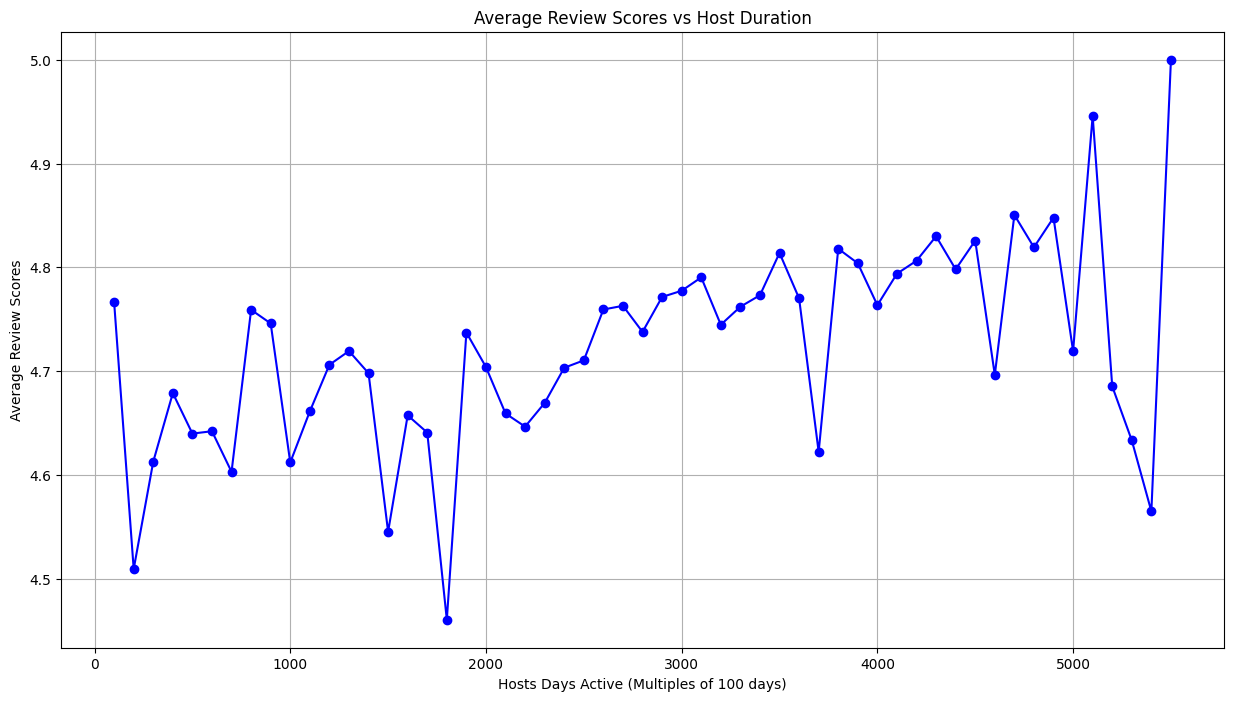

In [173]:
plt.figure(figsize=(15, 8))

plt.plot(
    average_rating_by_duration['Duration (Days Multiple of 100)'], 
    average_rating_by_duration['review_scores_rating'], 
    marker='o', 
    linestyle='-', 
    color='b'
)

plt.xlabel('Hosts Active Days (Multiples of 100 days)')
plt.ylabel('Average Review Scores')
plt.title('Average Review Scores vs Host Active Days')
plt.grid(True)
plt.show()

The trends of hosts' day active compared to the average review scores provides an interesting insight as if we refer back to hosts' active day against prices (code copied below for direct reference), the plot patterns are almost opposite of each other. This is especially prevelant in the first two plots and the last four. Hosts that are active for 3 months and less have a high average rating between 4.7 and 4.8 despite setting average prices of about $70, compared to hosts active for 3-6 months that set a higher average price of $140 with review scores just a little above 4.5/5. These two aspects might've directly affected each other, in a way that customers renting from 3-6 months old hosts having higher expectations of listings due to their higher value, and from the unmet expectations, consequently rate the place lower.

Analyzing the last four points, booking through 13 years 8 months - 11 months active host is more encouraged than a 13 years 11 months - 14 years 2 months active host. Not only are the ratings for these listings higher by 0.27 score, the prices are also cheaper by $45 per person and night. Lastly, hosts that have been active from 14 years and 9 months to 15 years show the most promising listing, they have the lowest average price range ($20-$90) and highest average rating (5/5).

Out of all the aspects against review scores, a host's active day has shown the most correlation. Aside from the clear rating drop for 100-200 days and 700-800 days host, and the gradual up and down values, there seem to be a positive trend. Meaning, the chances of getting higher quality and valued airbnbs are higher when opting to book with a host that has been in the industry for longer

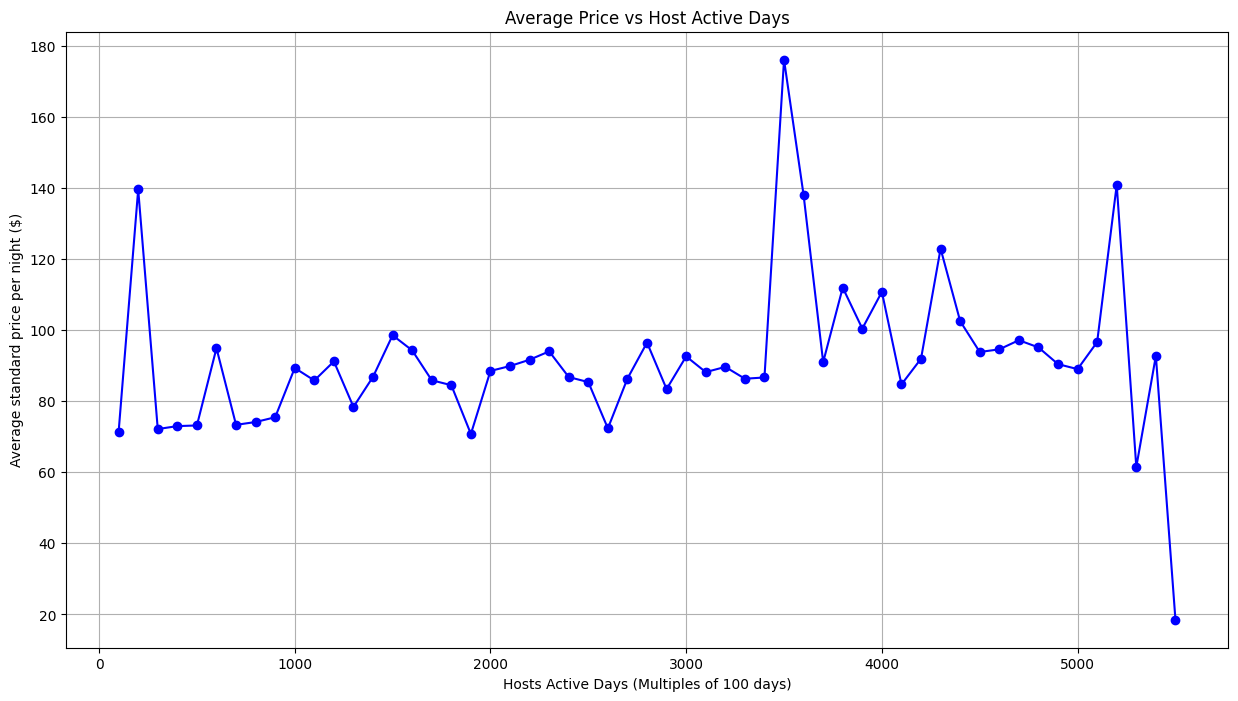

In [180]:
plt.figure(figsize=(15, 8))

plt.plot(
    average_price_by_duration['Duration (Days Multiple of 100)'], 
    average_price_by_duration['Average Price'], 
    marker='o', 
    linestyle='-', 
    color='b'
)

plt.xlabel('Hosts Active Days (Multiples of 100 days)')
plt.ylabel('Average standard price per night ($)')
plt.title('Average Price vs Host Active Days')
plt.grid(True)
plt.show()

##### Location and Rating

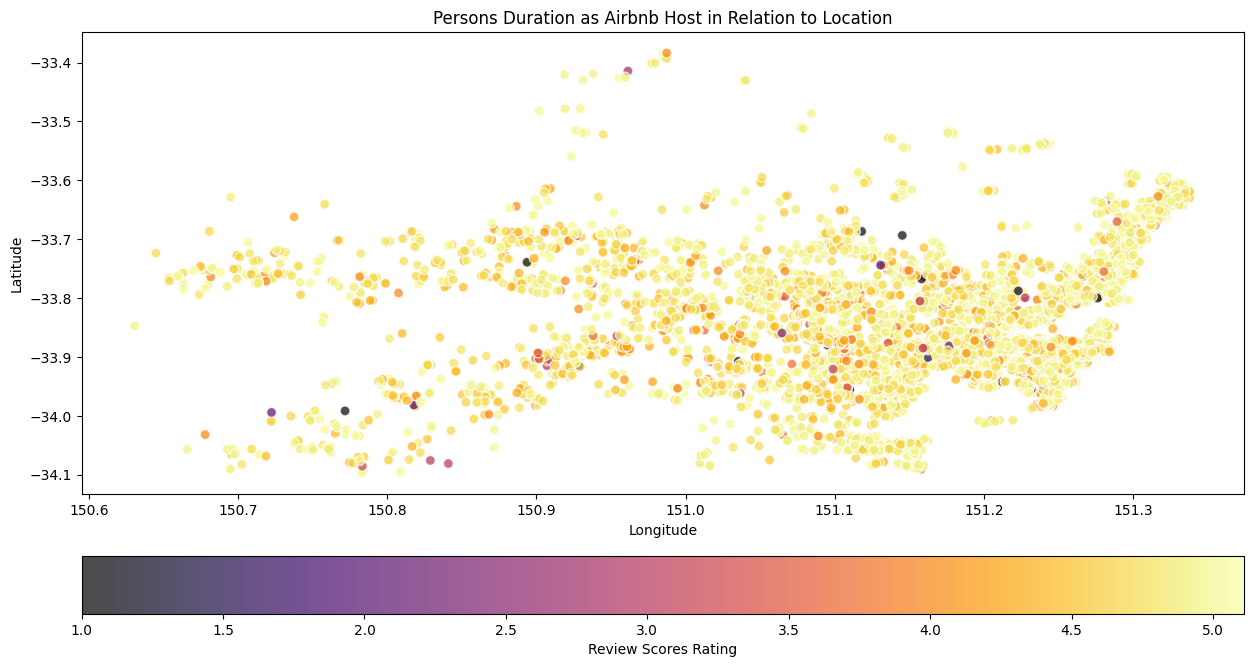

In [179]:
fig, ax = plt.subplots(figsize=(15, 8))

scatter = ax.scatter(
    filtered_price['longitude'], 
    filtered_price['latitude'], 
    c=filtered_price['review_scores_rating'], 
    cmap='inferno', 
    s=50, 
    alpha=0.7, 
    edgecolors='w'
)

cbar = plt.colorbar(scatter, orientation='horizontal', pad=0.1, ax=ax)
cbar.set_label('Review Scores Rating')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Airbnb Host Active Days in Relation to Location')

plt.show()

Through the graph, the mainly positive ratings of Sydney airbnbs are seen again, with most plots being colored light orange to yellow. Some bright orange plots are seen contrasting and sprinkled all around the city but there seems to not be any distinct pattern. These are mostly seen concentrated around the city center and expands slightly around the west and east. The coastal and southern areas are however colored slightly brighter in comparison, showing the more positive spread. From the previous location graphs, this makes sense as seaside properties tend to be listed by hosts that have been in the industry longer, which was established before to show higher reviews, and also has plot trends of higher prices.

##### Final Correlation Overview

Now let's calculate each of their correlation to review scores and see what affects the rating most

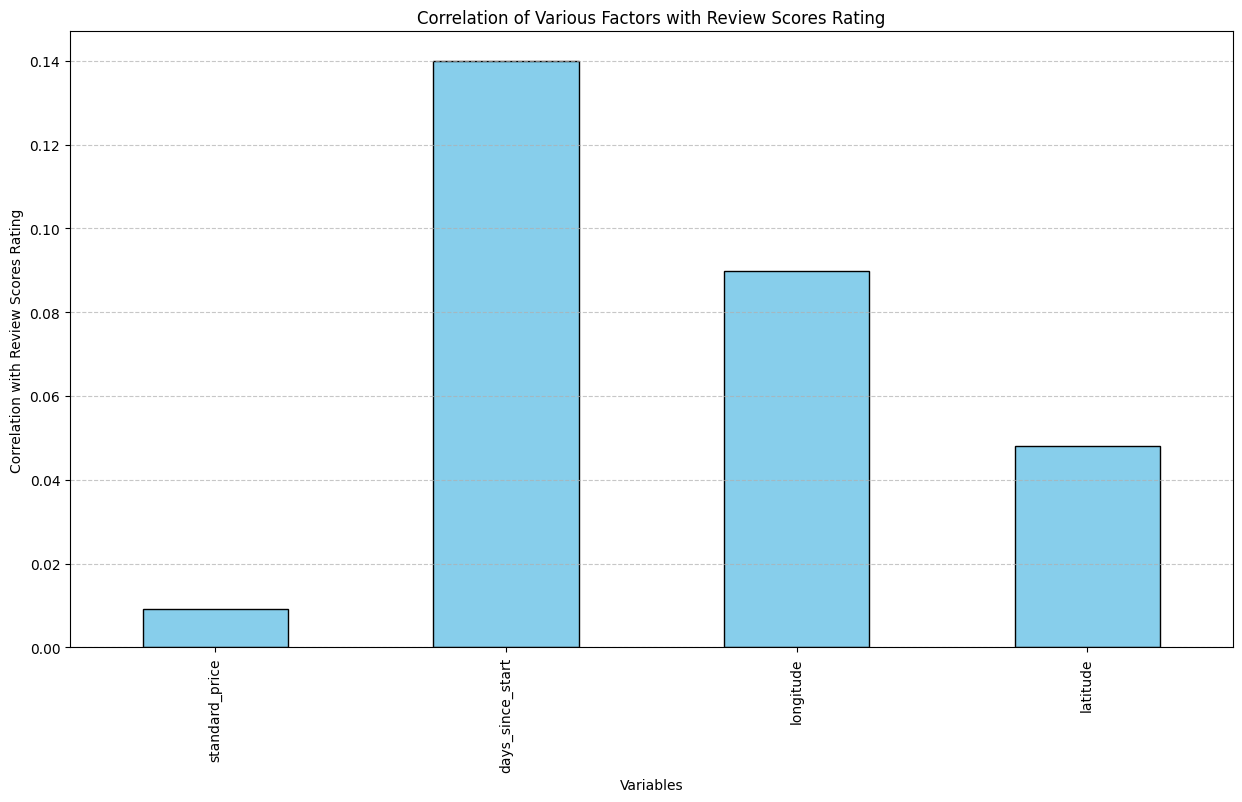

In [186]:
data_filtered = pd.DataFrame({
    'review_scores_rating': listing_data['review_scores_rating'],
    'standard_price': listing_data['standard_price'],
    'days_since_start': listing_data['days_since_start'],
    'longitude': listing_data['longitude'],
    'latitude': listing_data['latitude']
})

correlation_matrix = data_filtered.corr()

fig, ax = plt.subplots(figsize=(15, 8))

correlations = correlation_matrix['review_scores_rating'].drop('review_scores_rating')

# Bar plot for correlation with review scores
correlations.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')

# Set labels and title
ax.set_xlabel('Variables')
ax.set_ylabel('Correlation with Review Scores Rating')
ax.set_title('Correlation of Various Factors with Review Scores Rating')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


An increasing or more positive longitude refers to an eastern location, whereas a decreasing or more negative longitude refers to a western location.

An increasing or more positive latitude refers to a more northern location, whereas a decreasing or more negative latitude refers to a more southern location.

In conclusion, how long a host has been in the industry affects the review scores most, with a 0.14 value. Whereas longitude and latitude does affect and correlate with ratings, it is not by as much and perhaps just refer to the more northern and eastern points characteristics of Sydney beaches, as seen from previous analysis, might holds a higher price to book, but has a pattern of better review scores and more active hosts. With a value of 0.01, prices are the factor that affects review scores least. Paying more for an airbnb doesn't guarantee a better experience or quality.

Overall, as a customer on budget, there's no reason to sacrifice more money to book Sydney airbnbs. Instead more focus should be emphasized on finding a more active host and a more eastern and northern location. For a more financially flexible customer that's willing to spend more, finding a coastal/seaside airbnb with an active host is the most ideal method to apply for finding the best airbnb.